# Training a Sequence Classifier for MNIST

We can use an RNN, just like a CNN, to make predictions on the MNIST dataset. The only difference being that we will input the image flattened and unrolled into the RNN; we will treat each 28 x 28 pixels image as 28 rows or 28 pixels each. 

### Add diagram of the network we intend to create

### Construction of RNN

In [2]:
n_steps = 28 # Number of layers in the RNN
n_inputs = 28 # Number of recurrent neurons at each layer
n_neurons = 150 # Number of neurons in the 
n_outputs = 10 # Number of output classes

In [3]:
learning_rate = 0.001
momentum = 0.8

In [5]:
import tensorflow as tf

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs], name='X')
y = tf.placeholder(tf.int32, [None], name='y')

with tf.name_scope("RNN"):
    # https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
    # https://www.tensorflow.org/api_docs/python/tf/nn/rnn_cell
    basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
    # State is the final state, the output from the rightmost time_unrolled neuron
    # State is of shape (batch_size/n_neurons = 150, basic_cell.state_size = (150, )) 
    #     state.shape = (150, 150)
    outputs, state = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

with tf.name_scope("FC_SM_final_state"):
    # https://www.tensorflow.org/api_docs/python/tf/layers/dense
    # The dense layer performs the following operation: 
    #     logits = activation(inputs * weights + bias)
    # logits.shape = (150, 10) and inputs = state from final unrolled time step
    logits = tf.layers.dense(state, n_outputs)
    
    # https://deepnotes.io/softmax-crossentropy
    # https://sefiks.com/2017/12/17/a-gentle-introduction-to-cross-entropy-loss-function/
    # https://datascience.stackexchange.com/questions/9302/the-cross-entropy-error-function-in-neural-networks
    #
    # The mean of the cross entropy is used as the loss function. 
    #
    # We apply the softmax function to every row in the logits, i.e. every list
    # of length 10. Then calculate the log loss of every row (look at the 3rd link - stack overflow),
    # which we then return as a list of size (150, ). This is the cross entropy.
    # We find the mean of this and use this as the loss we are trying to reduce.
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy)
    tf.summary.scalar("losses", loss)
    
with tf.name_scope("Gradient_Descent"):
    optimizer = tf.train.MomentumOptimizer(momentum=momentum, learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("Metric"):
    # We look at each row in the logits and get the index of the value which has the 
    # highest probability. We then see if the index matches the expected y value for the 
    # number which we wanted to classify our image as.
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    tf.summary.scalar("accuracy", accuracy)

init = tf.global_variables_initializer()
merge = tf.summary.merge_all()

/Users/rajatrasal/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/rajatrasal/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Training

Using the Tensorflow wrapper for the MNIST dataset, we initialise a validation test set.

In [6]:
from tensorflow.examples.tutorials.mnist import input_data

# https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/#5
# https://www.oreilly.com/learning/not-another-mnist-tutorial-with-tensorflow

mnist = input_data.read_data_sets("tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

print(X_test.shape)
print(y_test.shape)

Extracting tmp/data/train-images-idx3-ubyte.gz
Extracting tmp/data/train-labels-idx1-ubyte.gz
Extracting tmp/data/t10k-images-idx3-ubyte.gz
Extracting tmp/data/t10k-labels-idx1-ubyte.gz
(10000, 28, 28)
(10000,)


We then train the RNN on minibatches of the MNIST dataset, calculating the training accuracy and validation accuracy after each training epoch.

In [7]:
n_epochs = 10
# batch_size = 150

with tf.Session() as sess:
    init.run()
    
    training_acc = []
    training_loss = []
    
    testing_acc = []
    testing_loss = []
    
    summary_writer = tf.summary.FileWriter('./logs/', sess.graph)
    
    for epoch in range(n_epochs):
        # Train RNN on each minibatch
        for i in range(mnist.train.num_examples // n_neurons):
            X_batch, y_batch = mnist.train.next_batch(n_neurons)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            l, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
            
        # Calculate training accuracy
        l, a = sess.run([loss, accuracy], feed_dict={X: X_batch, y: y_batch})
        """
        print("state_size:", state.eval(feed_dict={X: X_batch, y: y_batch}).shape)
        print("logits_size:", logits.eval(feed_dict={X: X_batch, y: y_batch}).shape)
        print("xentropy_size:", xentropy.eval(feed_dict={X: X_batch, y: y_batch}))
        """
        training_acc.append(a)
        training_loss.append(l)
        
        # Calculate validation accuracy
        l, a, summary = sess.run([loss, accuracy, merge], feed_dict={X: X_test, y: y_test})
        testing_acc.append(a)
        testing_loss.append(l)
        
        summary_writer.add_summary(summary, epoch)
        
        print(epoch, end=" ")

0 1 2 3 4 5 6 7 8 9 

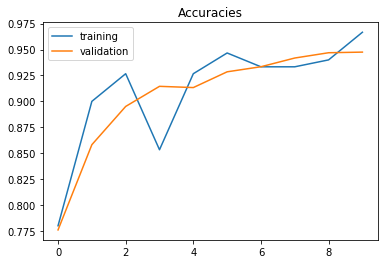

In [6]:
%matplotlib inline 
import matplotlib.pyplot as plt

fig = plt.subplot(111)
fig.set_title("Accuracies")
fig.plot(training_acc, label="training")
fig.plot(testing_acc, label="validation")
fig.legend()

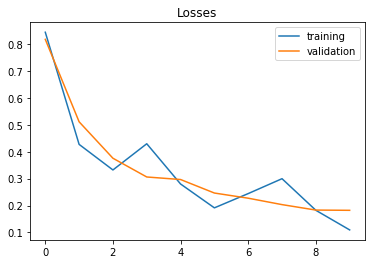

In [7]:
%matplotlib inline 

fig2 = plt.subplot(111)
fig2.set_title("Losses")
fig2.plot(training_loss, label="training")
fig2.plot(testing_loss, label="validation")
fig2.legend()

### Visualising the Model

Created a tensorboard subprocess. So even if the cell has been stopped, the tensorboard page will still be visible.

**So, we can run the cell and then stop it running by pressing the stop button in the toolbar above, and we will still be able to see the tensorboard page.**

In [ ]:
%%bash
tensorboard --logdir=./logs --port=8889 & # This will fail if it has already been run once.
# Make sure to manually stop this cell running (with the stop button in the toolbar) once it has run.

In [ ]:
from IPython.core.display import display, HTML
html = "<iframe src='http://localhost:8889' height=700 width=100%></iframe>"
display(HTML(data=html))